# Create model with PetitRadtrans

## Imports

In [1]:
from sys import path
path.append('/home/mathisb/Github/')

import os
os.environ['pRT_input_data_path'] = '/home/mathisb/projects/def-ncowan/input_data'

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
%matplotlib  inline

In [4]:
from astropy import constants as const
from astropy import units as u

from starships.planet_obs import Planet

import starships.petitradtrans_utils as prt
from petitRADTRANS.physics import guillot_global
from petitRADTRANS import Radtrans

import gc
from starships.spectrum import RotKerTransitCloudy

from astropy.modeling.physical_models import BlackBody as bb

## Planet info

In [5]:
# Specify planet name and parameters
# If not specified, the default parameters from exofile are taken.

pl_name = 'TRAPPIST-1 b'
planet_obj = Planet(pl_name)

# Most parameters are from trappist.one website
ap     = 0.01150*u.au       # semi-major axis of planet
R_star = 0.121*u.R_sun      # radius of star
R_pl   = 1.127*u.R_earth    # radius of planet
M_star = 0.089*const.M_sun  # mass of star
e      = 0                  # eccentricity
w      = 4.712389*u.rad     # argument of periapsis (equal to 270 degrees)
mid_tr = 2459514.805984833954*u.d  # mid-transit time (calculated from TTV BJD, Agol et al. 2021)

Getting TRAPPIST-1 b from ExoFile


/home/mathisb/HighRes/lib/python3.9/site-packages/exofile/archive.py:351: GetLocalFileWarning: DID NOT READ CUSTOM FILE. FileNotFoundError has occur when trying to query/read custom file.
  warn(GetLocalFileWarning(file="custom file", err=e))
/home/mathisb/HighRes/lib/python3.9/site-packages/astropy/units/quantity.py:486: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


## Create model

### H2O only

In [6]:
# Molecules to include in the model (one at a time)
molecules = ['H2O']

# Name of the linelists in petitradTRANS (see petitradtrans_utils.py lines 115-150)
mols_linelists = {'H2O': 'H2O_main_iso'}

# Priors for abundances (comment out if don't know abundances a priori)
# mol_vmr_log_save = {'H2O': -10.460962699336015,
#                     'CO': -4.5809756604704672,
#                     'CO2': -9.32730066887895,
#                     'FeH': -9.924607502078075,
#                     'TiO': -7.2940528637809345,
#                     'VO': -7.878547571395368,
#                     'C2H2': -7.86252539345477,
#                     'HCN': -7.059113617089739,
#                     'OH': -4.42793780398837,
#                     'H-': -8.672778478857413}

In [7]:
# Pull parameters from petitradTRANS
# Check limP and wl_range
atmos_high, pressures = prt.gen_atm_all([mols_linelists[key] for key in molecules],
                                        continuum_opacities=['H-'],
                                        limP=[-10, 2],  # log of TOA and surface pressure (unit: bar)
                                        n_pts=50, 
                                        mode='lbl',
                                        lbl_opacity_sampling=4,
                                        wl_range=[0.95, 2.35])  # wavelength range of instrument (unit: micrometers)

/home/mathisb/HighRes/lib/python3.9/site-packages/petitRADTRANS/radtrans.py:100: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


['H2O_main_iso']
  Read line opacities of H2O_main_iso...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

Generating atmosphere with pressures from 100.0 to 1e-10
You are not getting the individual contributions of the species


# WORK ON IT FROM HERE
## Get 1 notebook per planet
## In a notebook, have 1 section per model molecule

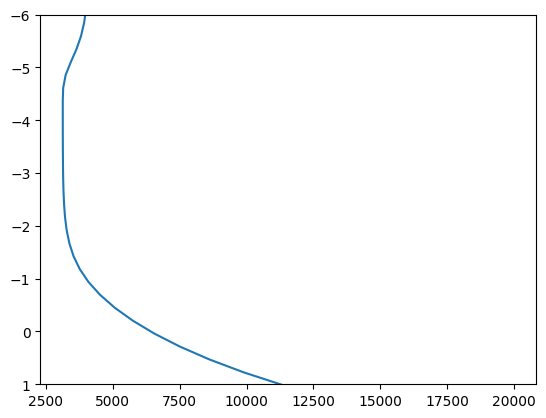

In [8]:




# CHANGE THIS (ask vignesh for good parameters)
#------------------------
T_int = 500.  # temp of interior of planet -- temperature of surface
T_eq = 3500.  # equilibrium temp of planet

radius = 1.5*const.R_jup
#------------------------

log_gamma = 0.5  # put opposite sign on this and log_kappa to inverse temp-pressure profile
log_kappa = -0.5

#------------------------

for log_kappa in [-1]:
    gravity = planet_obj.gp.cgs.value 
    kappa_IR = 10**(log_kappa)
    gamma = 10**log_gamma


    temp_params = {}
    temp_params['pressures'] = pressures
    temp_params['kappa_IR'] = kappa_IR
    temp_params['gamma'] = gamma
    temp_params['gravity'] = (const.G * planet_obj.M_pl / (radius)**2).cgs.value
    temp_params['T_int'] = T_int
    temp_params['T_eq'] = T_eq
    temp_params['M_pl'] = planet_obj.M_pl

    P0=10 *u.mbar.to(u.bar)  # pressure on the surface 
    # log_P0 = np.log10(P0)

    temperatures_day = guillot_global(temp_params['pressures'], 
                             temp_params['kappa_IR'], 
                             temp_params['gamma'], 
                             temp_params['gravity'], 
                             temp_params['T_int'], 
                             temp_params['T_eq'])
    plt.plot(temperatures_day, np.log10(pressures))         # MAKE THIS PLOT NICER
    plt.ylim(1,-6)

## Generating and plotting

In [9]:
%matplotlib inline

/home/mathisb/Github/starships/petitradtrans_utils.py:403: RuntimeWarning: invalid value encountered in log10
  plt.plot(np.log10(profile[key]), np.log10(pressures), label=key, color=cmap.colors[i])
/home/mathisb/Github/starships/petitradtrans_utils.py:955: RuntimeWarning: divide by zero encountered in true_divide
  out = atmos_object.transm_rad ** 2 / R_star ** 2


 pRT: negative radius correction applied!


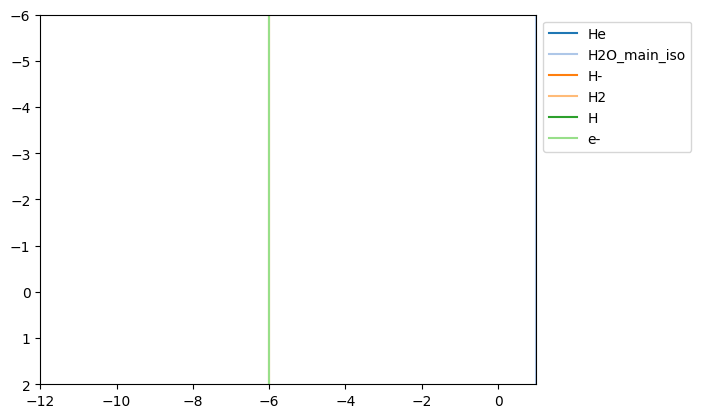

In [10]:
# Pressure zero
P0=10e-3  # don't change

cloud = None  # change if necessary

# Define abundances we want in model
# Only put molecules chosen earlier
# -2 = 0.02 fraction in atmosphere
# Negligible = -99
mol_vmr_log = {'H2O':1,
               'H-':-2,
               'e-':-8}  # don't change or remove

# species_high = species_high0.copy()
species_high = {mols_linelists[mol_name]: 10**(mol_vmr_log[mol_name])
                for mol_name in molecules}

species_high["H-"] = 1e-6  # don't change

wlen, flux_lambda = prt.retrieval_model_plain(atmos_high,
                                              species_high,
                                              planet_obj,
                                              pressures,
                                              temperatures_day,
                                              temp_params['gravity'],
                                              P0,
                                              cloud,
                                              planet_obj.R_pl.cgs.value,
                                              planet_obj.R_star.cgs.value,
                                              dissociation=False,
                                              plot_abundance=True,
                                              kind_trans='transmission')

wave_mod, model_spec_cont = prt.prepare_model(wlen, flux_lambda, 250000, Raf=64000, rot_params=None)
plt.plot(wave_mod, model_spec_cont)
plt.show()

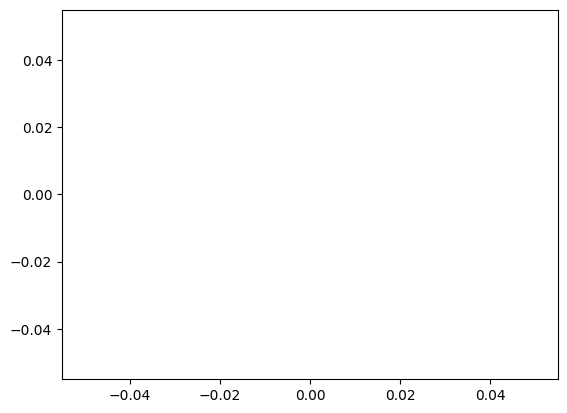

In [45]:
P0=10e-3

cloud = None

mol_vmr_log = {"H2O":5,
               "H-":-2,
               "e-":-8,}


species_high = {mols_linelists[mol_name]: 10**(mol_vmr_log[mol_name])
                for mol_name in molecules}

species_high["H-"] = 1e-6

wlen, flux_lambda = prt.retrieval_model_plain(atmos_high,
                                              species_high,
                                              planet_obj,
                                              pressures,
                                              temperatures_day,
                                              temp_params["gravity"],
                                              P0,
                                              cloud,
                                              planet_obj.R_pl.cgs.value,
                                              planet_obj.R_star.cgs.value,
                                              kind_trans="transmission")

wave_mod, model_spec_co_day = prt.prepare_model(wlen, flux_lambda, 250000, Raf=64000, rot_params=None)
plt.plot(wave_mod, model_spec_co_day)

In [ ]:
print(model_spec_co_day)

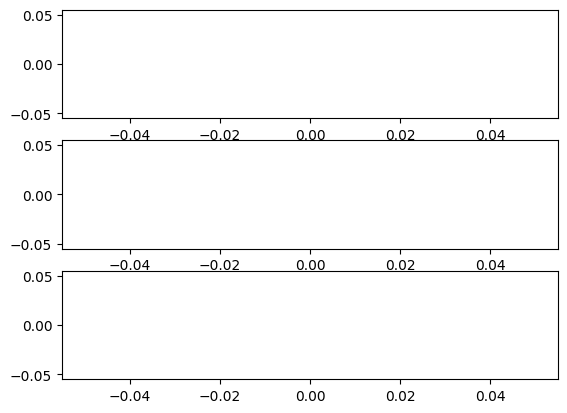

In [47]:
list_wv_range = [(1.17, 1.25), (1.55, 1.9), (2.33, 3.)]

fig, ax = plt.subplots(len(list_wv_range), 1)

try:
    len(ax)
except TypeError:
    ax = [ax]

for ax_i, wv_rng in  zip(ax, list_wv_range):
    cond = (wv_rng[0] < wave_mod) & (wave_mod < wv_rng[-1])
    ax_i.plot(wave_mod[cond], (model_spec_co_day/model_spec_cont)[cond])

plt.show()

In [50]:
np.savez('/home/mathisb/Github/HRS_models/test_mod_TRAPPIST-1_mixed_CO_main_iso', wave_mod=wave_mod, model_spec=model_spec_co_day)